In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spikes4 as spk4
import snn_models

# Parameters

In [2]:
#%% parameters
time_step = 1 # 1ms time resolution

lr = 0.002 # learning rate 0.005
thr = 0.6 # v threshold
tau_out = 3 # output decay time constant /// unit: ms
kappa = np.exp(-time_step/tau_out) # output decay
tau_mem = 20 # v decay time constant /// unit: ms
alpha = np.exp(-time_step/tau_mem) # v decay
beta = 0.2 # adaptation increment 
tau_a = 200 # adaptation decay time constant /// unit: ms
rho = np.exp(-time_step/(tau_a+1e-12)) # adaptation decay
t_ref = 2 # refractory period /// unit: ms

decays = np.array([lr, thr, alpha, beta, kappa, rho, t_ref]) # save as a vector

# Temporal credit assignment problem input generation

In [3]:
#%% input data generation
nb_inputs, nb_hidden, nb_outputs  = 40, 100, 2 # number of neurons
batch_size = 256
nb_batch = 10 # number of batches
nb_data = batch_size*nb_batch # =256*10
n_train = batch_size*(nb_batch-1) # =256*9
n_test = batch_size # =256*1
nb_steps = 500 # simulation duration (ms)
dur_stim = 100 # stimulation duration (ms)

x = np.zeros((nb_batch,batch_size,nb_steps,40)) # input dta train
y1hot = np.zeros((nb_batch,batch_size,nb_steps,2)) # target data (1hot encoding)
y = np.zeros((nb_batch,batch_size,nb_steps,)) # target data (0 for left, 1 for right, 0.5 otherwise)

for batch_idx in range(nb_batch):
    for b in range(batch_size):
        y_data = 0.5*np.ones((nb_steps)) 
        y_data1hot = np.zeros((nb_steps, 2))
        cue_on = np.zeros((nb_steps),dtype=bool) # learning cue, True when learing cue is on.
        
        prob_noise = 1*(time_step/1000) #!!! noise has 1Hz spike frequency
        x_data = np.random.choice(2, size=(nb_steps,nb_inputs),p=[1-prob_noise,prob_noise])
        
        t_stim = np.random.randint(0,350) # stimuli given random time interval [0,350]ms
        t_learn = 400 # learning cue starts at 400ms
        prob_stim = 40*(time_step/1000) #!!! input has 40Hz spike frequency
        x_stim = np.random.choice(2, size=(dur_stim,int(nb_inputs/4)),p=[1-prob_stim,prob_stim]).astype(float)
        l_or_r = np.random.choice(2) # left or right?
        x_data[t_stim:t_stim+dur_stim, int(nb_inputs/4)*l_or_r:int(nb_inputs/4)*l_or_r+int(nb_inputs/4)] = x_stim
        
        x_learn = np.random.choice(2, size=(dur_stim,int(nb_inputs/4)),p=[1-prob_stim,prob_stim]).astype(float)
        x_data[t_learn:t_learn+dur_stim, int(nb_inputs/4)*2:int(nb_inputs/4)*2+int(nb_inputs/4)] = x_learn
        
        y_data1hot[t_learn:t_learn+dur_stim, l_or_r] = 1
        cue_on[t_learn:t_learn+dur_stim] = True
        y_data[t_learn:t_learn+dur_stim] = l_or_r

        x[batch_idx,b] = x_data
        y[batch_idx,b] = y_data
        y1hot[batch_idx,b] = y_data1hot
print('data generated.')
stim = 2*y-1 # same as y, but -1 for left, 1 for right, and 0 otherwise

print(x.shape)
print(y.shape)
print(y1hot.shape)

data generated.
(10, 256, 500, 40)
(10, 256, 500)
(10, 256, 500, 2)


# Initialize weights

In [4]:
#%% initialize weight
weight_scale = 10*(1.0-alpha) #!!!
w1 = np.random.normal(size=(nb_inputs,nb_hidden), loc=0.0, scale=weight_scale/np.sqrt(nb_inputs)) # input-->hidden
w2 = np.random.normal(size=(nb_hidden,nb_outputs), loc=0.0, scale=weight_scale/np.sqrt(nb_hidden)) # hidden-->hidden
#bias = np.random.normal(size=(nb_outputs), loc=0.0, scale=weight_scale/np.sqrt(nb_outputs)) # output bias
bias = np.zeros(nb_outputs) # output bias
B = np.random.normal(size=(nb_outputs,nb_hidden), loc=0.0, scale=weight_scale/np.sqrt(nb_outputs)) #!!! random e-prop

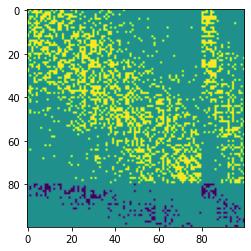

In [5]:
#%% recurrent weights (choose only one)
############### (1) random network ###############
# wr = np.random.normal(size=(nb_hidden,nb_hidden), loc=0.0, scale=weight_scale/np.sqrt(nb_hidden)) # hidden-->output
# np.fill_diagonal(wr,0) # no self connectivity

############### (2) E/I network ###############
import graph_analysis
nb_e = int(nb_hidden*0.8)
nb_i = nb_hidden - nb_e
ind_fromi = np.zeros((nb_hidden,nb_hidden),dtype=bool)
ind_fromi[nb_e:,:] = True # index of inhibitory neurons

wr, xy, cdens = graph_analysis.aij_distance2d([1000,1000], [250,150], nb_e, nb_i, np.array([[1,-1],[1,-1]]), cself=False, plot=False, randomseed=None)
wr = wr.T
wr *= 0.05 # scaling

plt.imshow(wr) # visualize initial weights

# Training

In [6]:
#%% compile (1st run numba is slow)
x_tmp, y1hot_tmp, cue_on_tmp = x[0,:,:3,:].copy(),y1hot[0,:,:3,:].copy(),cue_on[:3].copy()
loss, out_rec, dw1, dwr, dw2, dbias, v_rec, z_rec, a_rec = snn_models.lif_eprop(w1,wr,w2,bias,B,x_tmp, y1hot_tmp, cue_on_tmp,decays)
print('compile done.')

#%% run train
dw1_past = np.zeros((nb_inputs,nb_hidden))
dw2_past = np.zeros((nb_hidden,nb_outputs))
dwr_past = np.zeros((nb_hidden,nb_hidden))
dbias_past = np.zeros((nb_outputs,))
loss_train, fr_train, acc_train, spktr, wrs, atr = [],[],[],[],[],[]
loss_valid, fr_valid, acc_valid = [],[],[]
n_epochs = 16
for epoch in range(n_epochs): # 100
    ######################### train #########################
    loss_batch,acc_batch,fr_batch = np.zeros((nb_batch-1,)), np.zeros((nb_batch-1,)), np.zeros((nb_batch-1,))
    for batch_idx in range(nb_batch-1): # batch_idx = 0
        x_batch,y1hot_batch,y_batch = x[batch_idx],y1hot[batch_idx],y[batch_idx]
        loss, out_rec, dw1, dwr, dw2, dbias, v_rec, z_rec, a_rec = snn_models.lif_eprop(w1,wr,w2,bias,B,x_batch,y1hot_batch,cue_on,decays)
        dw1_past = 0.9*dw1_past + np.mean(dw1,0) #!!! momentum=0.9
        dw2_past = 0.9*dw2_past + np.mean(dw2,0) #!!! momentum=0.9
        dwr_past = 0.9*dwr_past + np.mean(dwr,0) #!!! momentum=0.9
        dbias_past = 0.9*dbias_past + np.mean(dbias,0) #!!! momentum=0.9 #AKSHAY
        
        w1 += dw1_past # input-->hidden update
        w2 += dw2_past # hidden-->hidden update
        wr += dwr_past # hidden-->output update
        bias += dbias_past # bias update #AKSHAY
        
        # w1 += np.mean(dw1,0) # these are for no-momentum update (slow learning)
        # w2 += np.mean(dw2,0)
        # wr += np.mean(dwr,0)
        # bias += np.mean(dbias,0)
        # np.fill_diagonal(wr,0) # no-self connectivity

        #!!! below 5 lines are valid only for E/I network (uncomment when using random network) 
        ind_negative = wr<0
        ind = ind_negative*(~ind_fromi) # find negative & exciatory neurons
        wr[ind] = 0. # force the negative weights to 0
        ind = (~ind_negative)*ind_fromi # find positive & inhibitory neurons
        wr[ind] = 0. # force the positive weights to 0
        
        pi = np.exp(out_rec[:,cue_on,:])/np.exp(out_rec[:,cue_on,:]).sum(2).reshape(batch_size,dur_stim,1) # sfotmax /// [batch_size,dur_stim,2]
        pi_m = pi.mean(1)
        acc_batch[batch_idx] = (np.argmax(pi_m,axis=1) == y_batch[:,cue_on][:,-1]).mean() # save cc
        
        loss_batch[batch_idx] = loss.mean() # save loss
        fr_batch[batch_idx] = 1000*z_rec.mean() # save firing rate
    loss_train.append(loss_batch.mean()) # save loss 
    acc_train.append(acc_batch.mean()) # save acc
    fr_train.append(fr_batch.mean()) # save firing rate
    print('EPOCH %d TRAIN) loss: %0.4f, acc: %0.4f, fr: %0.4f Hz' %(epoch, loss_train[epoch], acc_train[epoch], fr_train[epoch]))

    ######################### validate #########################
    x_batch,y1hot_batch,y_batch = x[-1],y1hot[-1],y[-1] # the last batch is for valid data
    loss, out_rec, dw1, dwr, dw2, dbias, v_rec, z_rec, a_rec = snn_models.lif_eprop(w1,wr,w2,bias,B,x_batch,y1hot_batch,cue_on,decays)
    
    
    pi = np.exp(out_rec[:,cue_on,:])/np.exp(out_rec[:,cue_on,:]).sum(2).reshape(batch_size,dur_stim,1) # softmax /// [batch_size,dur_stim,2]
    pi_m = pi.mean(1)
    acc_valid.append((np.argmax(pi_m,axis=1) == y_batch[:,cue_on][:,-1]).mean()) # save acc
    
    loss_valid.append(loss.mean()) # save loss
    fr_valid.append(1000*z_rec.mean()) # save firing rate
    print('EPOCH %d VALID) loss: %0.4f, acc: %0.4f, fr: %0.4f Hz' %(epoch, loss_valid[epoch], acc_valid[epoch], fr_valid[epoch]))
        
    spktr.append(z_rec[0]) # save spike train /// save one batch data only to save memory
    atr.append(a_rec[0]) # save a trace
    wrs.append(wr.copy()) # save weights
    
    ######################### save best weights #########################
    if loss_valid[-1] == min(loss_valid): # or you can use acc criteria instead
        w1_save,w2_save,wr_save,bias_save = w1.copy(),w2.copy(),wr.copy(),bias.copy()
        epoch_best = epoch
spktr = np.stack(spktr,0)
atr = np.stack(atr,0)
wrs = np.stack(wrs,0)
N = int(n_epochs/8) # epoch interval for plotting

compile done.
EPOCH 0 TRAIN) loss: 69.3859, acc: 0.4883, fr: 0.4267 Hz
EPOCH 0 VALID) loss: 69.3534, acc: 0.5273, fr: 0.4411 Hz
EPOCH 1 TRAIN) loss: 69.3786, acc: 0.5030, fr: 0.4729 Hz
EPOCH 1 VALID) loss: 69.3521, acc: 0.4688, fr: 0.5375 Hz
EPOCH 2 TRAIN) loss: 69.3744, acc: 0.4983, fr: 0.6048 Hz
EPOCH 2 VALID) loss: 69.3623, acc: 0.4688, fr: 0.7020 Hz
EPOCH 3 TRAIN) loss: 69.3687, acc: 0.5026, fr: 0.7995 Hz
EPOCH 3 VALID) loss: 69.3200, acc: 0.4961, fr: 0.9191 Hz
EPOCH 4 TRAIN) loss: 69.3230, acc: 0.5030, fr: 1.0711 Hz
EPOCH 4 VALID) loss: 69.2486, acc: 0.5703, fr: 1.2208 Hz
EPOCH 5 TRAIN) loss: 69.1965, acc: 0.5404, fr: 1.4180 Hz
EPOCH 5 VALID) loss: 69.0674, acc: 0.6758, fr: 1.6155 Hz
EPOCH 6 TRAIN) loss: 68.8936, acc: 0.6194, fr: 1.8458 Hz
EPOCH 6 VALID) loss: 68.6286, acc: 0.8164, fr: 2.0795 Hz
EPOCH 7 TRAIN) loss: 68.3132, acc: 0.7300, fr: 2.3176 Hz
EPOCH 7 VALID) loss: 67.8987, acc: 0.8711, fr: 2.5880 Hz
EPOCH 8 TRAIN) loss: 67.5347, acc: 0.8177, fr: 2.8545 Hz
EPOCH 8 VALID) lo

# Visualization

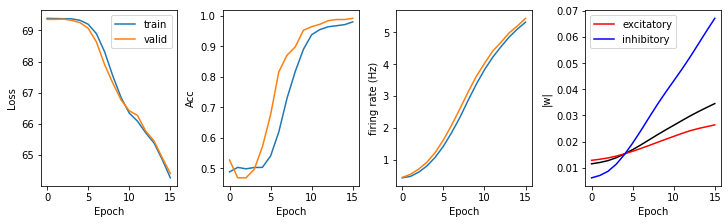

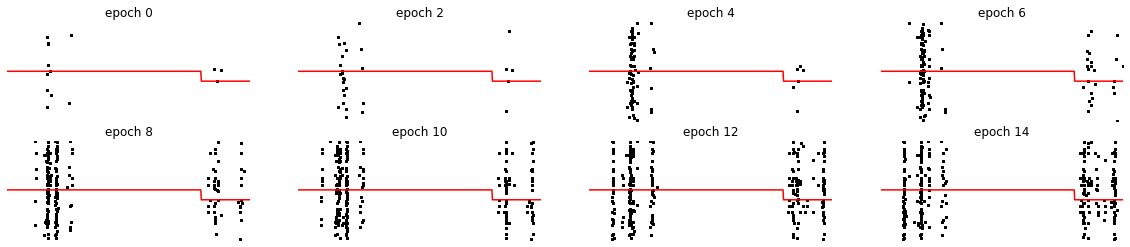

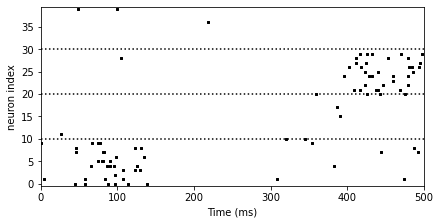

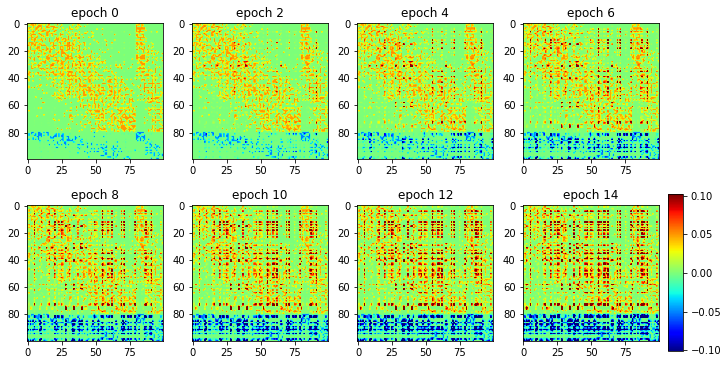

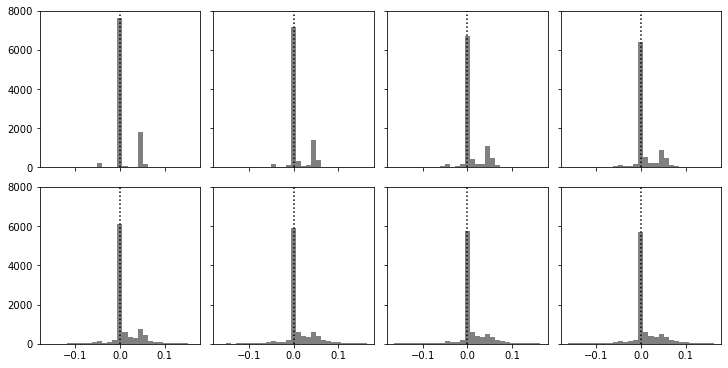

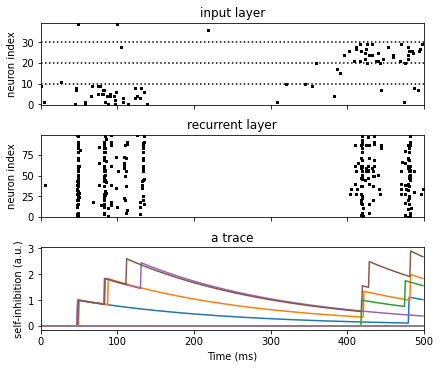

In [7]:
######################### visualization #########################
#%% loss, acc, and firing rate as a function of epoch
fig,axes = plt.subplots(1,4,figsize=(10,3),constrained_layout=True, sharex=True)
axes[0].plot(loss_train,label='train')
axes[0].plot(loss_valid,label='valid')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_xlabel('Epoch')

axes[1].plot(acc_train)
axes[1].plot(acc_valid)
axes[1].set_ylabel('Acc')
axes[1].set_xlabel('Epoch')

axes[2].plot(fr_train)
axes[2].plot(fr_valid)
axes[2].set_ylabel('firing rate (Hz)')
axes[2].set_xlabel('Epoch')

axes[3].plot(np.abs(wrs).mean(2).mean(1),'k')
axes[3].plot(np.abs(wrs[:,:nb_e,:]).mean(2).mean(1),'r',label='excitatory') #!!! uncomment when using random network
axes[3].plot(np.abs(wrs[:,nb_e:,:]).mean(2).mean(1),'b',label='inhibitory') #!!! uncomment when using random network
axes[3].set_ylabel('|w|')
axes[3].set_xlabel('Epoch')
axes[3].legend()
#%% raster plot
b = 0
fig,axes = plt.subplots(2,4,sharex=True,sharey=True,figsize=(20,4))
axes = axes.flatten()
for j in range(8):
    spktr_tmp = spktr[N*j]
    spk4.rasterplot(spktr_tmp, ax=axes[j])
    axes[j].plot(nb_hidden/2+10*stim[-1,b],'r')
    axes[j].axis('off')
    axes[j].set_title('epoch %d' %(N*j))

fig = plt.figure(figsize=(6,3),constrained_layout=True)
spk4.rasterplot(x_batch[b], fs=0, markersize=3, t0=0, color='k')
plt.axhline(y=10,linestyle=':',c='k')
plt.axhline(y=20,linestyle=':',c='k')
plt.axhline(y=30,linestyle=':',c='k')
plt.xlabel('Time (ms)')
plt.ylabel('neuron index')
plt.savefig('raster.png')
#%% weight matrix plot
fig,axes = plt.subplots(2,4,constrained_layout=True,figsize=(10,5))
axes = axes.flatten()
cmax = 2*np.std(np.abs(wrs))
for j in range(8):
    im = axes[j].imshow(wrs[N*j], vmin=-cmax, vmax=cmax, cmap='jet')
    axes[j].set_title('epoch %d' %(N*j))
plt.colorbar(im, ax=axes[-1])
plt.savefig('weight_matrix.png')
#%% weight distribution
fig,axes = plt.subplots(2,4,constrained_layout=True,figsize=(10,5),sharex=True,sharey=True)
axes = axes.flatten()
wmax = 3*np.std(wrs)
for j in range(8):
    axes[j].hist(wrs[N*j].flatten(),bins=np.linspace(-wmax, wmax, 30),color='gray')
    axes[j].axvline(x=0,c='k',linestyle=':')
plt.savefig('weight_dist.png')
#%% save weights
import pickle
fname = r'weight_lr_v2.pkl'
file = open(fname, "wb")
dict_data = {'w1':w1_save, 'w2':w2_save, 'wr':wr_save, 'bias':bias_save}
pickle.dump(dict_data, file)
file.close()
#%% example trace and raster
b = 0
fig,axes = plt.subplots(3,1,figsize=(6,5),constrained_layout=True, sharex=True)
spk4.rasterplot(x_batch[b], fs=0, markersize=3, t0=0, color='k', nrn0=0, ax=axes[0])
axes[0].axhline(y=10,linestyle=':',c='k')
axes[0].axhline(y=20,linestyle=':',c='k')
axes[0].axhline(y=30,linestyle=':',c='k')
axes[0].set_title('input layer')
axes[0].set_ylabel('neuron index')

spk4.rasterplot(spktr[epoch_best], ax=axes[1])
axes[1].set_title('recurrent layer')
axes[1].set_ylabel('neuron index')

# axes[0].set_title('pred: %d vs. target: %d' %(np.argmax(pi[b]), y[b,-1]))
axes[2].plot(atr[epoch_best,:,:8])
axes[2].set_title('a trace')
axes[2].set_ylabel('self-inhibition (a.u.)')
axes[2].set_xlabel('Time (ms)')

plt.savefig('trace_raster.png')